# Analyzing Job data in USA

In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext rpy2.ipython

In [3]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

The data is gathered by crawling Indeed.com for the number of job openings for various roles like Data Scientist, Data Analyst and Data Engineer for 45 major cities in US  

In [4]:
# Reading the job data
jobDf = pd.read_csv('/Users/sakshisingla/Downloads/DataJobs.csv')

In [5]:
jobDf.head()

,City,State,Data Scientist,Data Analyst,Data Engineer
0,Raleigh,NC,156,262,1534
1,Madison,WI,17,106,351
2,Columbus,OH,72,233,764
3,Charlotte,NC,95,334,1048
4,San Diego,CA,156,236,1698


In [11]:
%R library(ggmap)
%R library(devtools)

array(['usethis', 'devtools', 'ggmap', 'ggplot2', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [12]:
%%R
library(maps) # For map data

In [7]:
# Get longitude and latitude data for all cities in US using maps library

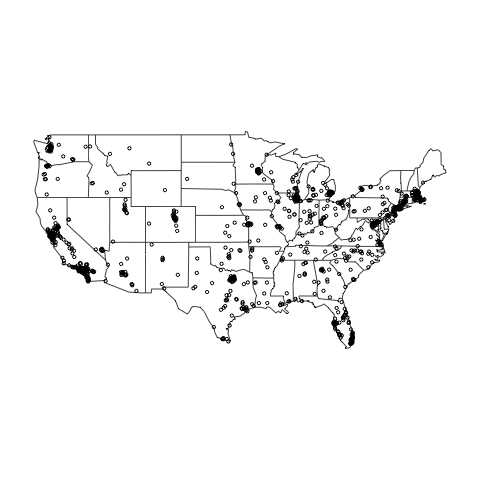

In [61]:
%%R
map("state")
data(us.cities)
map.cities(us.cities)


In [14]:
#Aggregating job data to get total number of jobs in each city
jobDf['TotalJobs']=jobDf['Data Scientist']+jobDf['Data Engineer']+jobDf['Data Analyst']
jobDf.head()

,City,State,Data Scientist,Data Analyst,Data Engineer,TotalJobs
0,Raleigh,NC,156,262,1534,1952
1,Madison,WI,17,106,351,474
2,Columbus,OH,72,233,764,1069
3,Charlotte,NC,95,334,1048,1477
4,San Diego,CA,156,236,1698,2090


In [21]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [23]:
#Get dataframe from R to pandas environment and modifying it to bring in required format
df_cities_us=r['us.cities']
df_cities_us=df_cities_us.rename(columns={'country.etc':'country'})
df_cities_us['cityName']=df_cities_us.name.str[:-3]
df_cities_us.head()

,name,country,pop,lat,long,capital,cityName
1,Abilene TX,TX,113888,32.45,-99.74,0,Abilene
2,Akron OH,OH,206634,41.08,-81.52,0,Akron
3,Alameda CA,CA,70069,37.77,-122.26,0,Alameda
4,Albany GA,GA,75510,31.58,-84.18,0,Albany
5,Albany NY,NY,93576,42.67,-73.80,2,Albany


In [25]:
#Merging the job data with cities data to get longitudes and latitudes for all the cities
CityJobMerge=pd.merge(jobDf,df_cities_us,left_on='City',right_on='cityName',how='left')
CityJobMerge.head()

,City,State,Data Scientist,Data Analyst,Data Engineer,TotalJobs,name,country,pop,lat,long,capital,cityName
0,Raleigh,NC,156,262,1534,1952,Raleigh NC,NC,350822.0,35.82,-78.66,2.0,Raleigh
1,Madison,WI,17,106,351,474,Madison AL,AL,39516.0,34.70,-86.75,0.0,Madison
2,Madison,WI,17,106,351,474,Madison WI,WI,227642.0,43.08,-89.39,2.0,Madison
3,Columbus,OH,72,233,764,1069,Columbus GA,GA,184900.0,32.51,-84.87,0.0,Columbus
4,Columbus,OH,72,233,764,1069,Columbus IN,IN,39453.0,39.21,-85.91,0.0,Columbus


In [26]:
#Adding longitudes and latitudes for Washington because was not there in dataset
CityJobMerge.loc[CityJobMerge.City=='Washington','lat']=38.9072
CityJobMerge.loc[CityJobMerge.City=='Washington','long']=-77.0369


In [28]:
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [30]:
#Fixing the dataframe for upload in R
CityJobMerge = fixDFcolsForR(CityJobMerge)

In [31]:
%R -i CityJobMerge

In [33]:
# Getting map data for states

In [34]:
%%R
library(maps)
states_map <- map_data("state")

In [36]:
#map not looking good because of presence of Honolulu. 


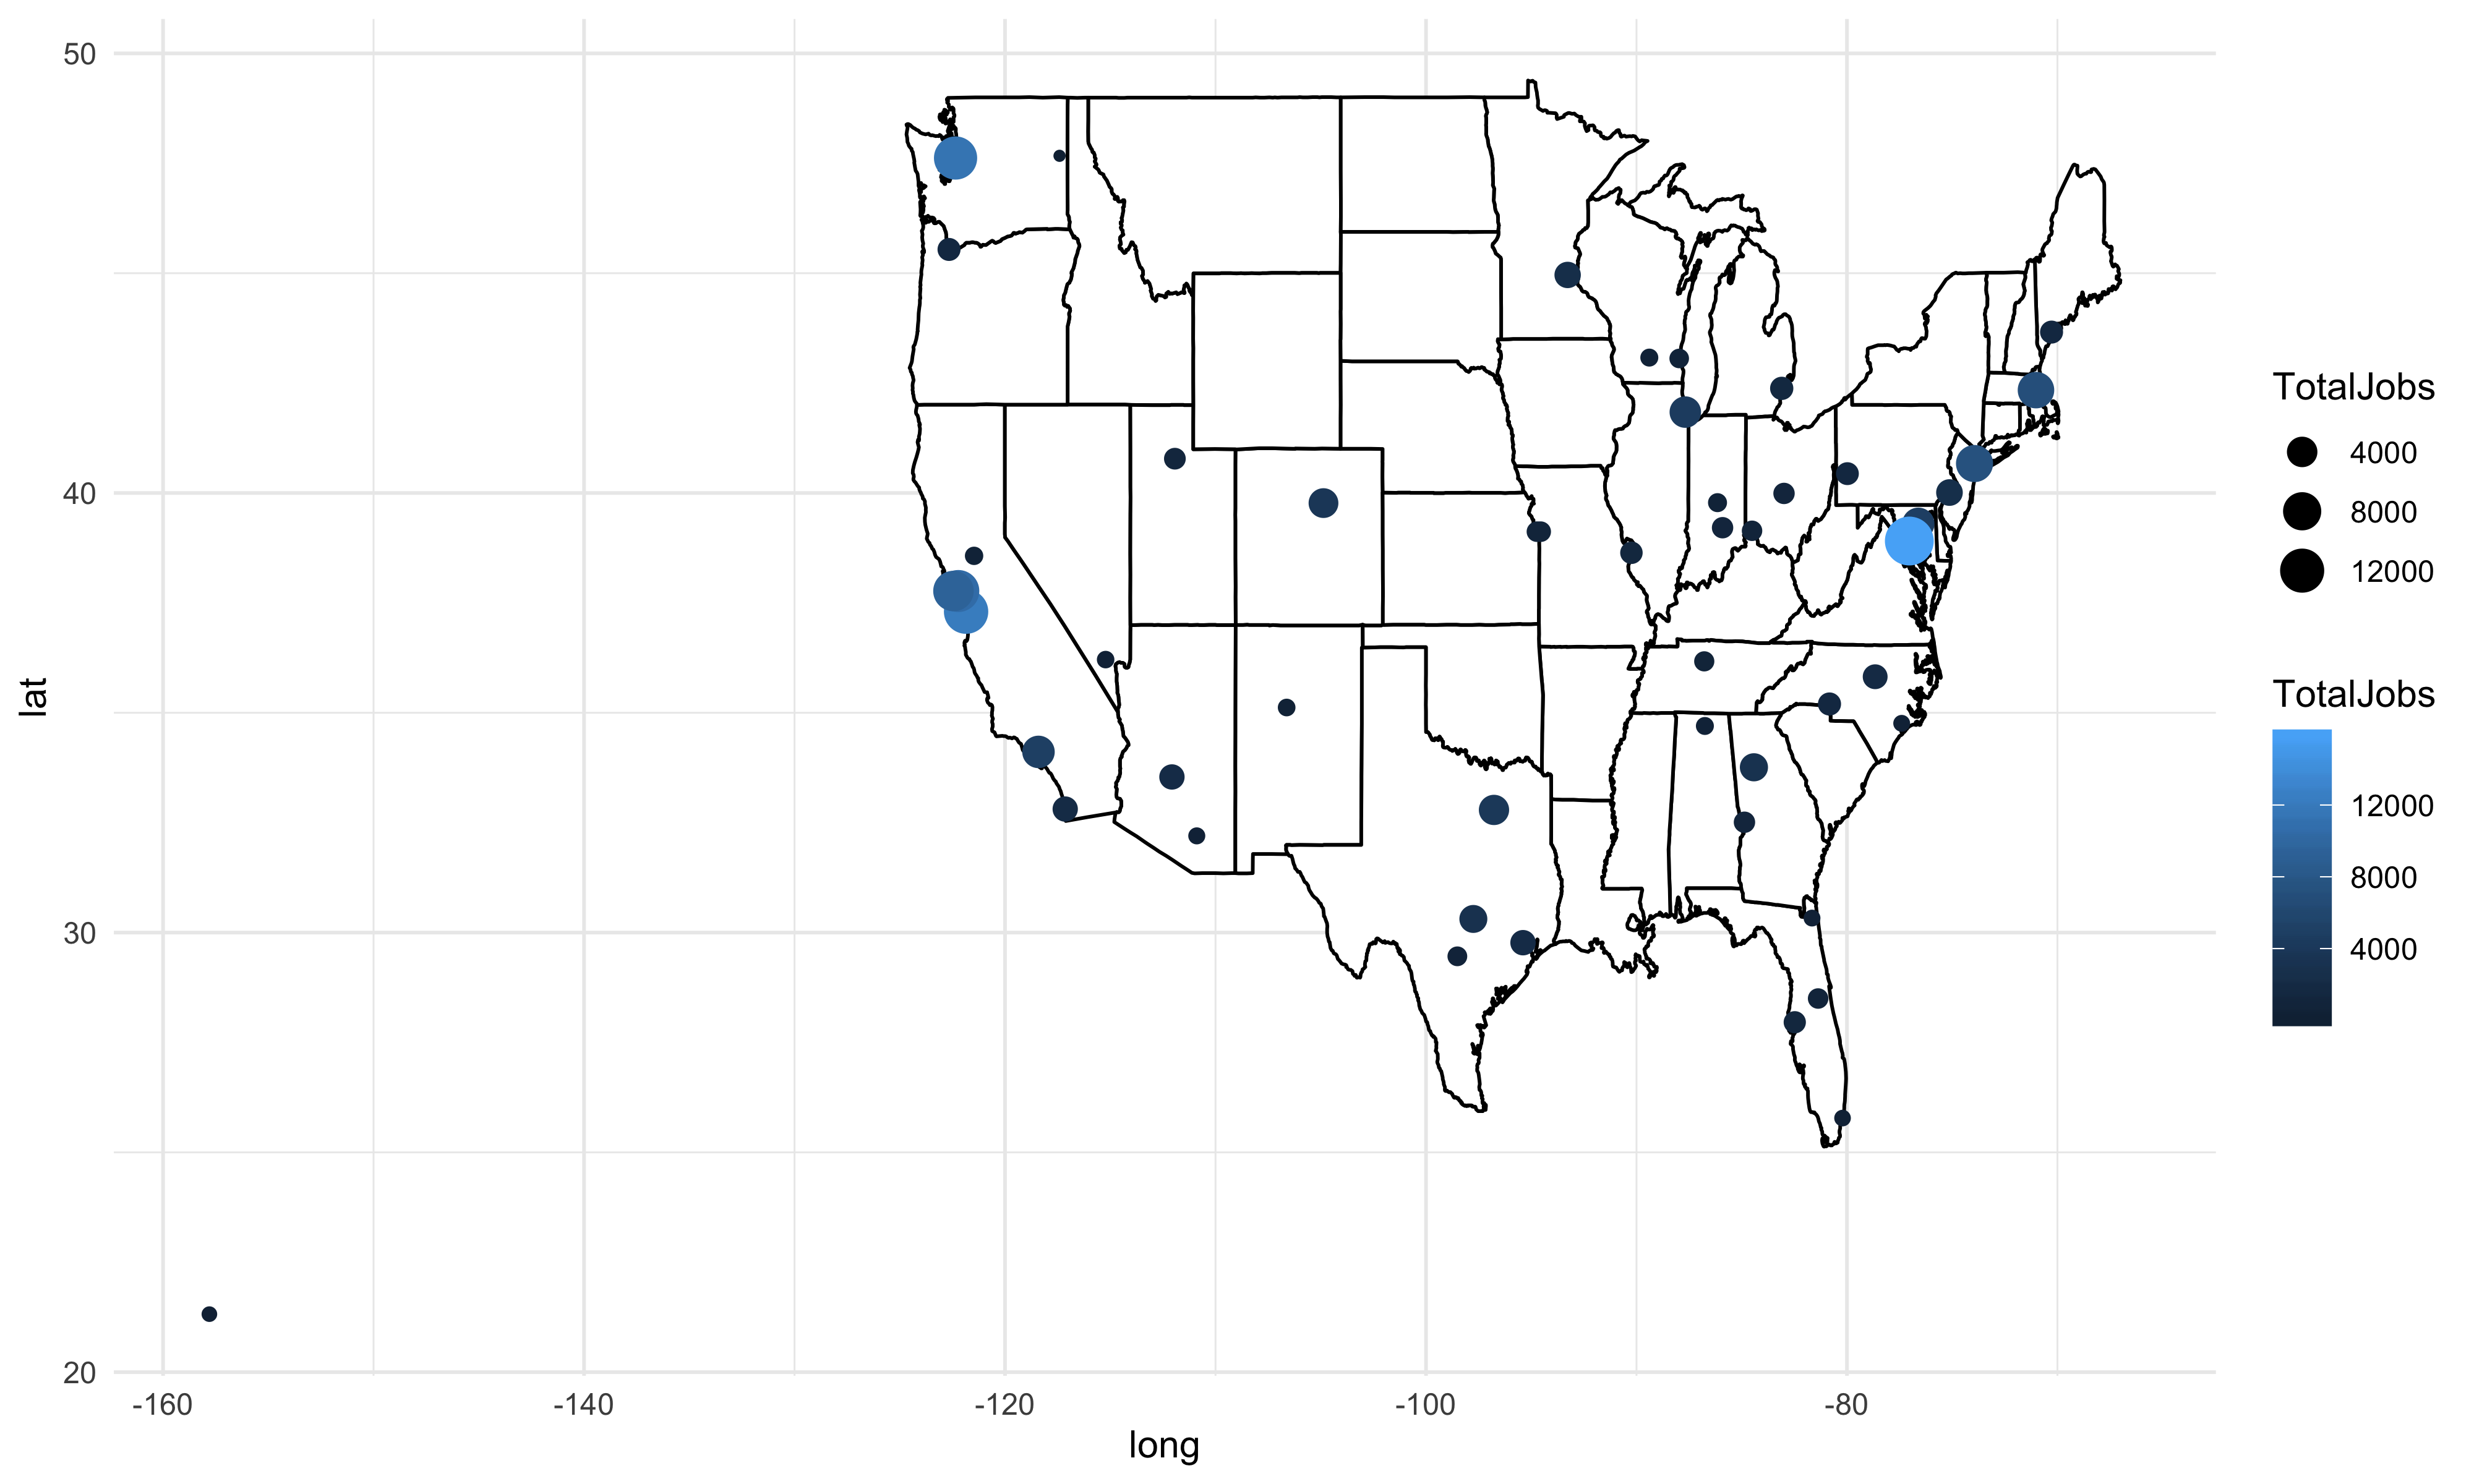

In [37]:
%%R -w 10 -h 6 --units in  -r 400 
ggplot() +theme_minimal()+
        geom_polygon(data=states_map, aes(x=long, y=lat, group=group),fill="white", colour="black")+
    geom_point(data = CityJobMerge, mapping = aes(x = long, y = lat, size = TotalJobs, color=TotalJobs))

In [40]:
# Removing it because anyways it is not having many number of data science jobs.
CityJobMerge2=CityJobMerge.loc[~(CityJobMerge.City=='Honolulu')]
%R -i CityJobMerge2


In [41]:
# Get data for 10 cities having largest number of data science jobs
largestJobCities=CityJobMerge2.nlargest(10,'TotalJobs')
largestJobCities['vadjust']=[0.5,1,-0.1,0.5,-0.4,-0.1,-0.1,-0.1,-0.1,-0.1]
largestJobCities['hadjust']=[-0.1,-0.1,-0.1,-0.1,0.6,-0.1,-0.1,-0.1,-0.1,-0.1]
%R -i largestJobCities
majorJobCities=largestJobCities['City']
CityJobMerge2['colour']=0
CityJobMerge2.loc[CityJobMerge2.City.isin(majorJobCities),'colour']=1
%R -i CityJobMerge2
CityJobMerge2.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


City               object
State              object
Data Scientist      int64
Data Analyst        int64
Data Engineer       int64
TotalJobs           int64
name               object
country            object
pop               float64
lat               float64
long              float64
capital           float64
cityName           object
colour              int64
dtype: object

# Generating the Plot1: Bubble map showing 10 top cities with data science jobs

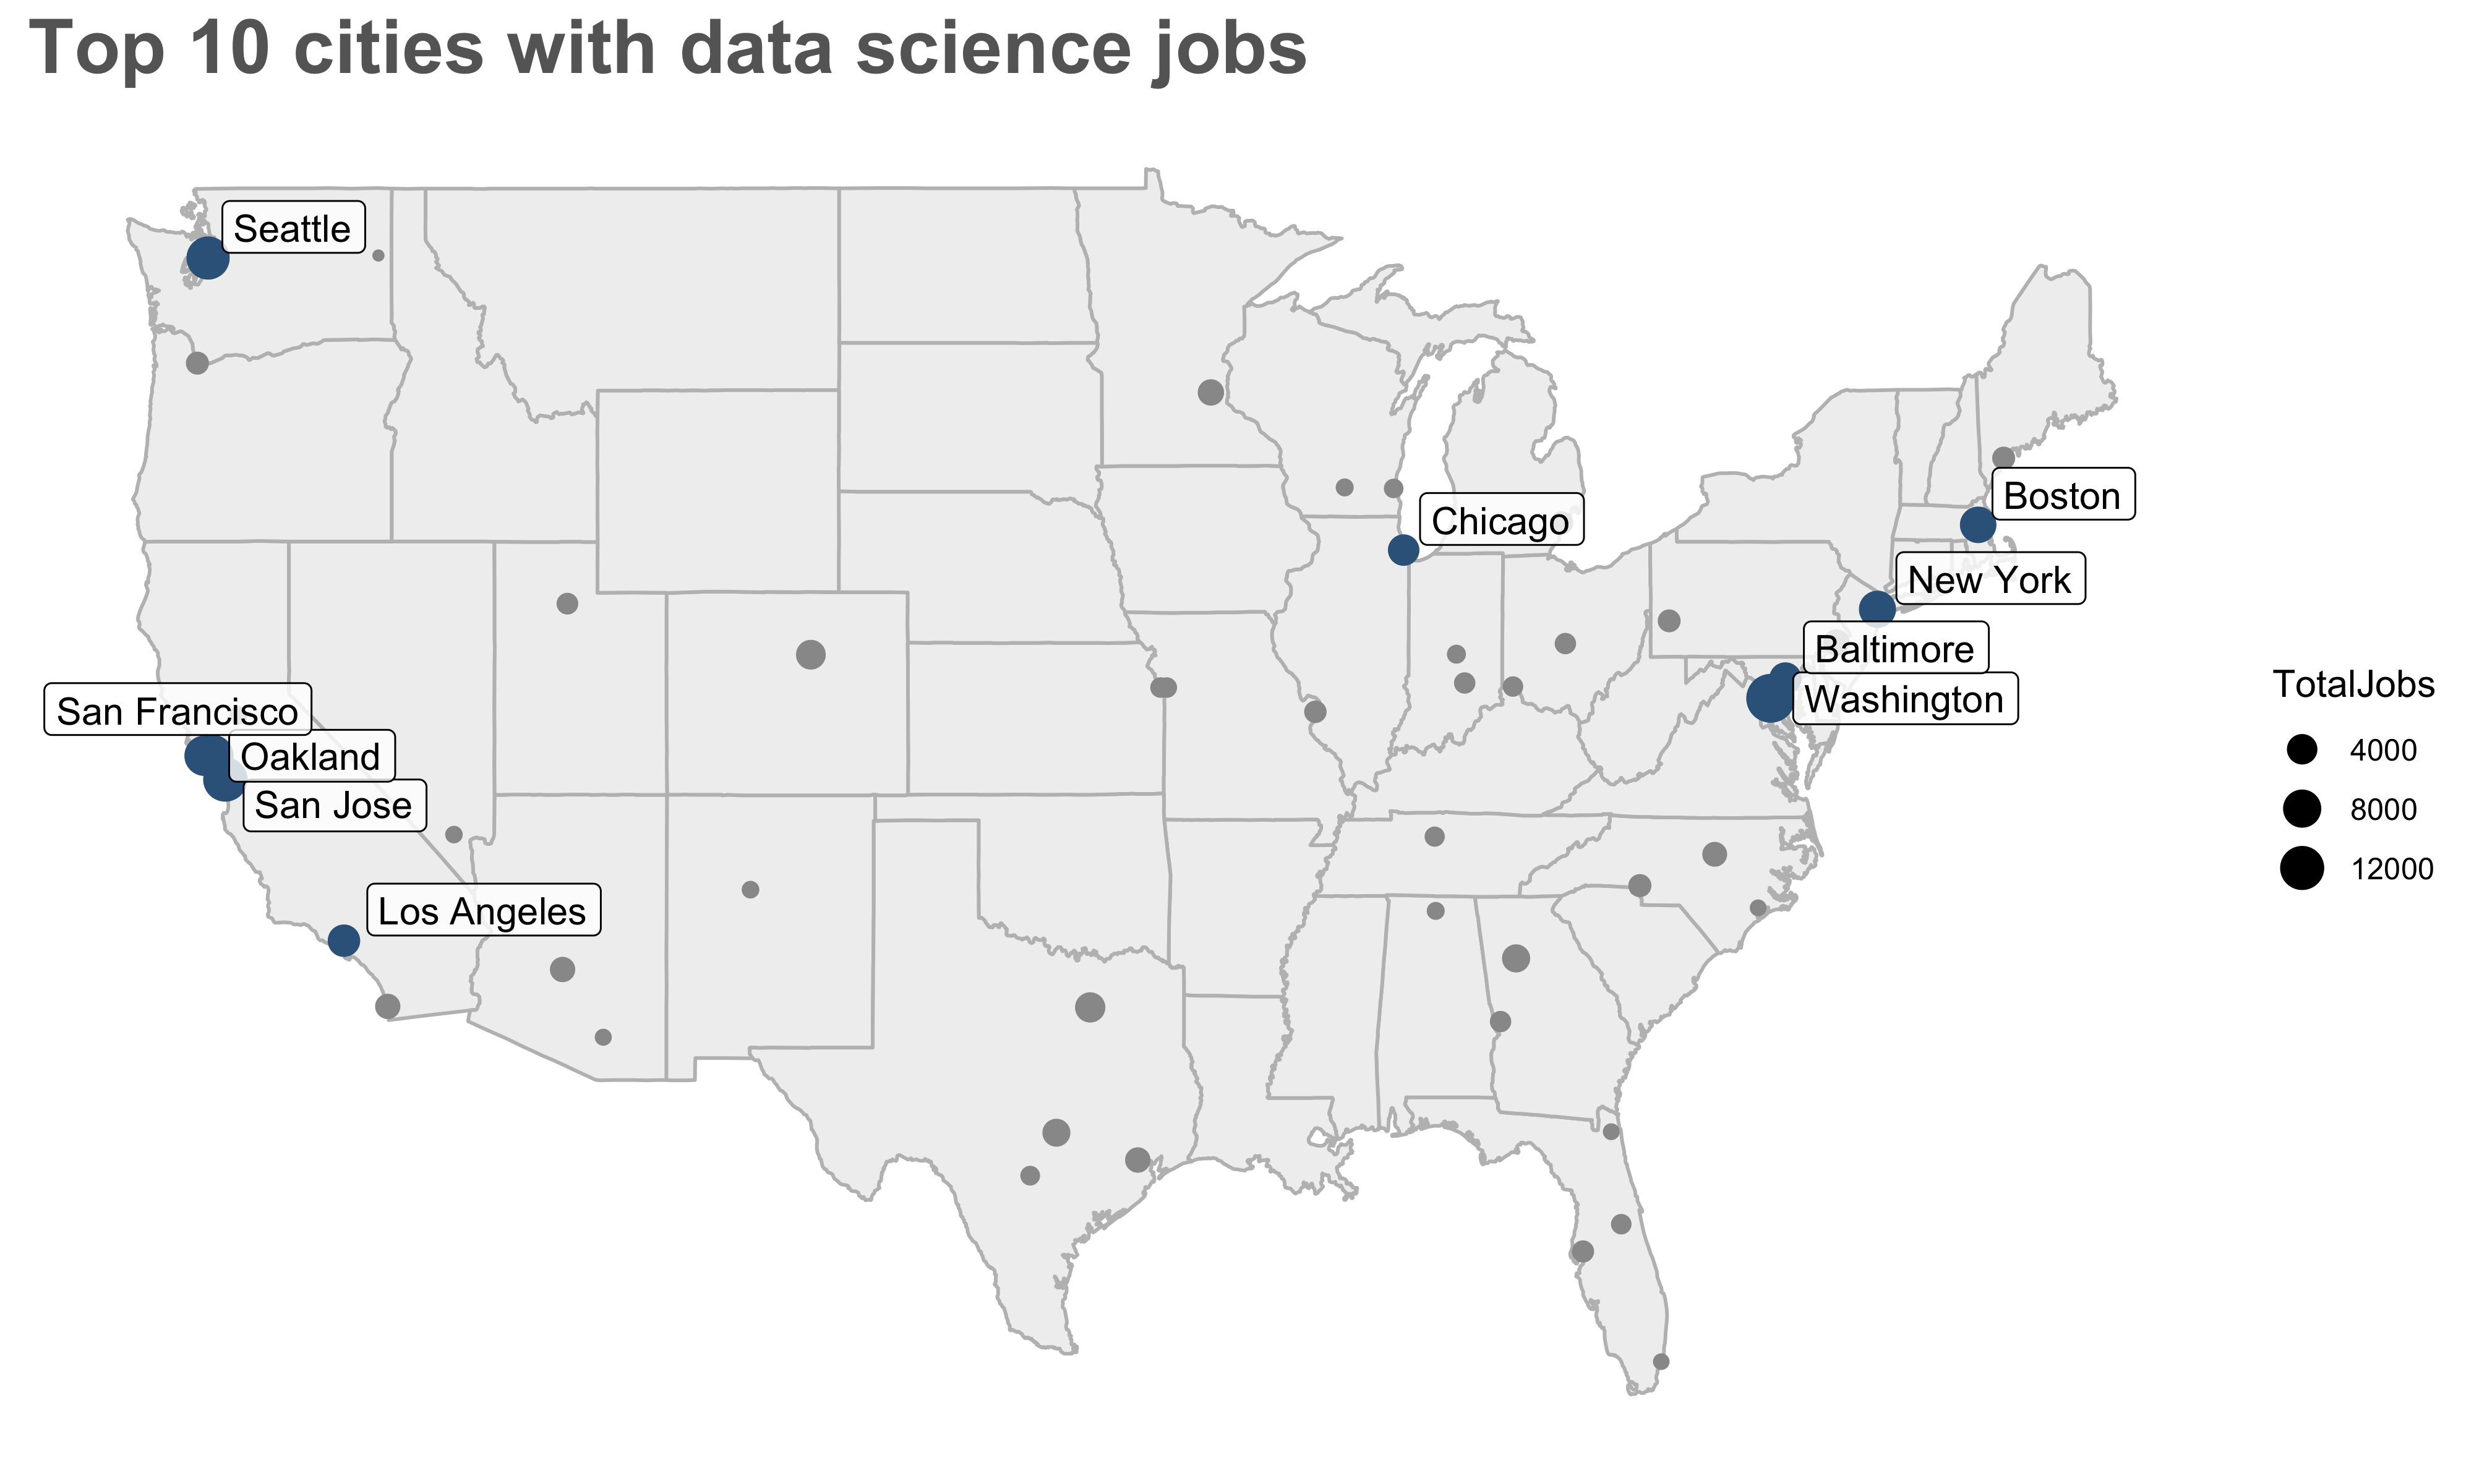

In [42]:
%%R -w 10 -h 6 --units in  -r 400 
ggplot() +theme_minimal()+
ggtitle("Top 10 cities with data science jobs")+
        geom_polygon(data=states_map, aes(x=long, y=lat, group=group),fill="gray94", color="gray")+
    geom_point(data = CityJobMerge2, mapping = aes(x = long, y = lat, size = TotalJobs, color=colour))+
geom_label(data = largestJobCities, aes(x = long, y = lat, label=City,vjust=vadjust,hjust=hadjust),alpha = 0.8)+
scale_colour_gradient(low = "gray60", high = "steelblue4")+
  theme(plot.title = element_text(color='grey40', size=22, face='bold'),
      axis.title=element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank())+guides(colour=FALSE)


# Second Plot: Average salary per city and comparison with national average

In [ ]:
# The data is gathered by crawling Glassdoor website for the average salary in 10 top job cities 

In [47]:
incomeDf = pd.read_csv('/Users/sakshisingla/Downloads/JobIncome.csv')

In [55]:
incomeDf

,City,State,Data Scientist,Data Analyst,Data Engineer,Avg_Base_Salary,Percent_Variation_with_National_Avg
0,San Jose,CA,1278,601,10301,128471,21
1,Oakland,CA,1134,833,8528,128595,21
2,San Francisco,CA,979,783,7686,128595,21
3,Seattle,WA,1097,550,9688,116372,10
4,Los Angeles,CA,322,660,3917,107970,2
5,New York,NY,896,1218,5222,103929,-2
6,Boston,MA,753,908,5345,100526,-5
7,Baltimore,MD,169,388,4252,96917,-9
8,Chicago,IL,383,896,3156,95122,-10
9,Washington,DC,1286,2261,12252,94954,-11


Calculating national average:

In [49]:
#Seattle is having 10% salary more than national average
# 1.1x=116372
# x=116372/1.1=105792.72727272726

In [57]:
#Doing data modifications to show in the graph.
df_income=incomeDf[['City','Avg_Base_Salary']].rename(columns={'Avg_Base_Salary':'salary'})
df_income=df_income.sort_values('salary', ascending=False)
df_income["salary"]=df_income["salary"]/1000
df_income.loc[df_income.City=='Washington','colour']=1
df_income.loc[df_income.City=='San Jose','colour']=0
%R -i df_income
df_income

,City,salary,colour
1,Oakland,128.595,NaN
2,San Francisco,128.595,NaN
0,San Jose,128.471,0.0
3,Seattle,116.372,NaN
4,Los Angeles,107.970,NaN
5,New York,103.929,NaN
6,Boston,100.526,NaN
7,Baltimore,96.917,NaN
8,Chicago,95.122,NaN
9,Washington,94.954,1.0


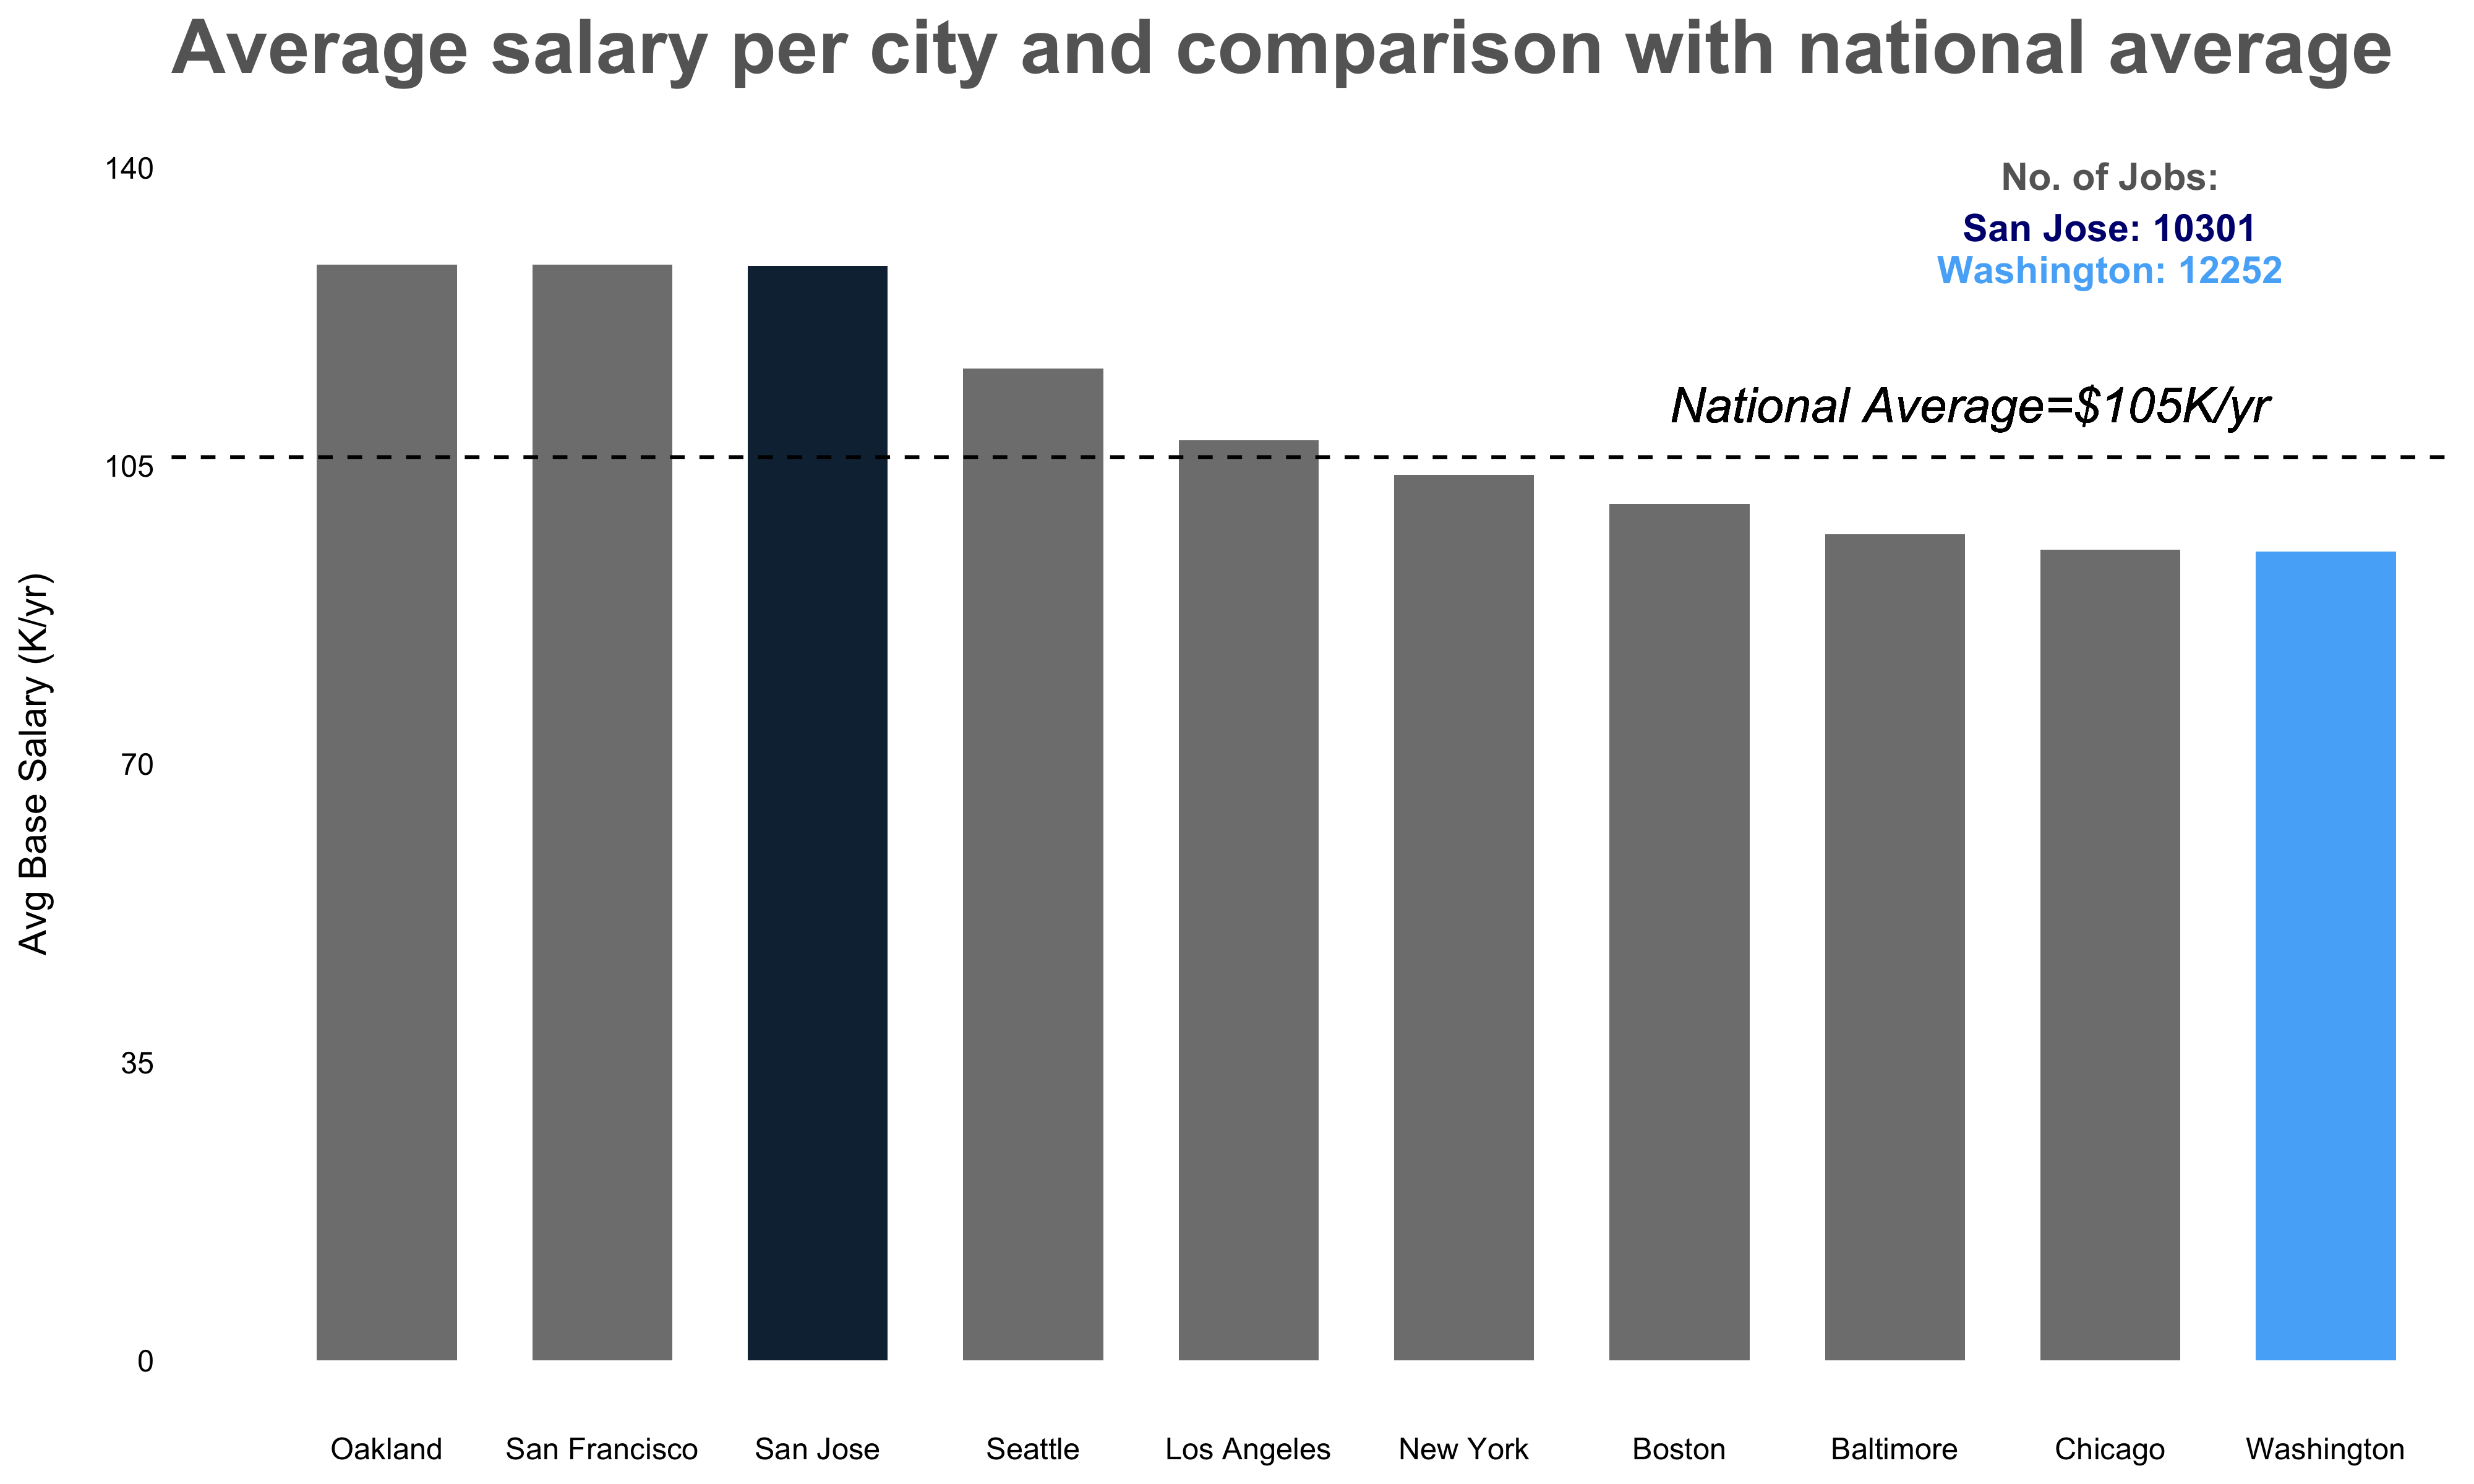

In [60]:
%%R -w 10 -h 6 --units in  -r 400 
ggplot(df_income, aes(x=factor(City, levels=unique(City)), y=salary)) +theme_minimal()+ 
ggtitle("Average salary per city and comparison with national average")+
geom_bar(aes(fill=colour),stat="identity",width=0.65)+
ylab("Avg Base Salary (K/yr)\n") +
geom_hline(yintercept = 106, linetype = 'dashed') +
geom_text(aes(0,106,label = "National Average=$105K/yr",hjust=-2.5, vjust = -1), fontface="italic",size=5)+
scale_colour_gradient( high="navyblue", low = "#56B1F7")+
scale_y_continuous(limits = c(0, 140),breaks = seq(0, 140, by = 35))+
annotate("text", x = 9, y = 139,label = "No. of Jobs:",fontface="bold", color='grey40') +
annotate("text", x = 9, y = 133,label = "San Jose: 10301",fontface="bold", color='navyblue') +
annotate("text", x = 9, y = 128,label = "Washington: 12252",fontface="bold", color='#56B1F7') +
theme(plot.title = element_text(color='grey40', size=22, face='bold'),
    axis.title.x=element_blank(), 
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), 
    axis.text = element_text(color="black"),
     legend.position = "none")